### To crawl Vietnamese Stock Price Data, there are plenty of website provide APIs to scrape data to local machine. In this project, I prefer solution by calling APIs library from Mr.Thinh Vu - vnstock. Origin from: https://github.com/thinh-vu/vnstock

In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install vnstock

In [3]:
from vnstock import *

##### Import name of stock company

In [4]:
stock_company = ['ACB', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'KDH', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'PNJ', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIC', 'VJC', 'VNM','VPB', 'VRE']
print(len(stock_company))

30


In [5]:
stock_list = []

stock = pd.DataFrame()
df = pd.DataFrame()
for company in stock_company:
    stock = stock_historical_data(symbol=company, start_date='2019-01-01', end_date='2024-02-29', resolution='1D', type="stock", beautify=True, decor=False, source='DNSE')
    stock_list.append(stock)
stock_list

[            time   open   high    low  close    volume ticker
 0     2019-01-02   9360   9360   9140   9230   1103106    ACB
 1     2019-01-03   8310   9200   8310   8890   1956382    ACB
 2     2019-01-04   8850   9010   8730   8950   2771983    ACB
 3     2019-01-07   9140   9140   9010   9070   1305819    ACB
 4     2019-01-08   9920   9920   9010   9010    846226    ACB
 ...          ...    ...    ...    ...    ...       ...    ...
 1279  2024-02-23  27700  28400  27300  27300  25975600    ACB
 1280  2024-02-26  27300  27700  27100  27500   9785600    ACB
 1281  2024-02-27  27700  27700  27350  27600  12054800    ACB
 1282  2024-02-28  27650  28000  27550  28000  10460800    ACB
 1283  2024-02-29  28100  28250  27700  28000   9951400    ACB
 
 [1284 rows x 7 columns],
             time   open   high    low  close   volume ticker
 0     2019-01-02  22960  22960  22320  22360   805700    BID
 1     2019-01-03  22360  22560  21350  21350  1107500    BID
 2     2019-01-04  21020  2132

In [6]:
# Save as .csv for optional analysis

for stock in stock_list:
    csv_filename = f"stock/{stock['ticker'].iloc[0]}.csv"
    stock.to_csv(csv_filename, index=False)


## Take example on VIC stock price to analyse basic statistic.

In [7]:
data = pd.read_csv('stock/VIC.csv')
data

,time,open,high,low,close,volume,ticker
0,2019-01-02,89945,90034,86656,89234,602450,VIC
1,2019-01-03,88878,89145,87278,89145,496950,VIC
2,2019-01-04,88878,89500,87101,89412,458000,VIC
3,2019-01-07,89678,91545,88789,89767,589150,VIC
4,2019-01-08,90656,90656,88612,89767,494300,VIC
...,...,...,...,...,...,...,...
1284,2024-02-23,47950,47950,45200,45200,9877200,VIC
1285,2024-02-26,45350,45750,44300,44600,5089400,VIC
1286,2024-02-27,44800,45650,44350,45150,4367500,VIC
1287,2024-02-28,45900,46400,45250,45600,3369700,VIC


In [8]:
# Data desciption
data.describe()

,open,high,low,close,volume
count,1289.000000,1289.000000,1289.000000,1289.000000,1.289000e+03
mean,81532.623739,82396.242824,80456.754073,81506.862684,2.168222e+06
std,21313.778725,21497.821633,21182.035046,21343.788080,3.193304e+06
min,39700.000000,40500.000000,38700.000000,40400.000000,9.045000e+04
25%,62500.000000,63300.000000,60800.000000,62000.000000,5.942100e+05
50%,85323.000000,86212.000000,84079.000000,85501.000000,1.374300e+06
75%,100440.000000,101677.000000,99544.000000,100788.000000,2.341300e+06
max,127985.000000,129674.000000,127096.000000,127985.000000,2.822080e+07


D:\anaconda3\envs\Tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\envs\Tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\envs\Tensorflow\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\envs\Tensorflow\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

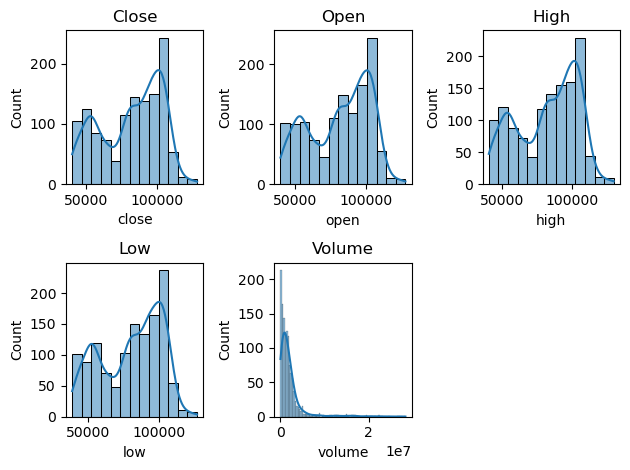

In [9]:
# Close
plt.subplot(2, 3, 1)
sns.histplot(data['close'], kde=True)
plt.title('Close')

# Open
plt.subplot(2, 3, 2)
sns.histplot(data['open'], kde=True)
plt.title('Open')

# High
plt.subplot(2, 3, 3)
sns.histplot(data['high'], kde=True)
plt.title('High')

# Low
plt.subplot(2, 3, 4)
sns.histplot(data['low'], kde=True)
plt.title('Low')

# Volume
plt.subplot(2, 3, 5)
sns.histplot(data['volume'], kde=True)
plt.title('Volume')

plt.tight_layout()
plt.show()

In [10]:
data.isnull().sum().sum()

0

In [11]:
data

,time,open,high,low,close,volume,ticker
0,2019-01-02,89945,90034,86656,89234,602450,VIC
1,2019-01-03,88878,89145,87278,89145,496950,VIC
2,2019-01-04,88878,89500,87101,89412,458000,VIC
3,2019-01-07,89678,91545,88789,89767,589150,VIC
4,2019-01-08,90656,90656,88612,89767,494300,VIC
...,...,...,...,...,...,...,...
1284,2024-02-23,47950,47950,45200,45200,9877200,VIC
1285,2024-02-26,45350,45750,44300,44600,5089400,VIC
1286,2024-02-27,44800,45650,44350,45150,4367500,VIC
1287,2024-02-28,45900,46400,45250,45600,3369700,VIC
